In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sumolib
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule

In [3]:

import sys
sys.path.append('..')

from util_folder.ml_utils.result_utils.plot_utils import plotNet_colormap_w_norm
import matplotlib.colors as mcolors
from util_folder.dotdict import DotDict

In [22]:
# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large_long'
incident_data_module = IncidentDataModule(folder_path = folder_path,
                                          transform='scalenormalize',
                                          spatial_test=False,
                                          subset_size=None,
                                          batch_size = 100)
incident_data_module.setup()
train_dataloader = incident_data_module.train_dataloader()
train_dataset = train_dataloader.dataset
val_dataloader = incident_data_module.val_dataloader()
val_dataset = val_dataloader.dataset
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

*** DATA SUMMARY: ***
input_obs_full.shape=torch.Size([10270, 147, 6, 15, 3])
input_time_full.shape=torch.Size([10270, 147, 6, 15, 2])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



In [5]:
test_edges = ['4414080#0.187', 
                '4414080#0.756', 
                '4414080#0', 
                '332655581', 
                '360361373-AddedOffRampEdge', 
                '360361373.2643' ]
selected_edges = torch.zeros(147)
edge_to_ind = {v:k for k, v in ind_to_edge.items()}
test_edge_idxs = torch.tensor([int(edge_to_ind[edge]) for edge in test_edges])
selected_edges[test_edge_idxs] = 1

In [6]:
edge_to_ind = {v:k for k, v in ind_to_edge.items()}

In [7]:
test_edge_idxs = torch.tensor([int(edge_to_ind[edge]) for edge in test_edges])

In [8]:
test_edge_idxs

tensor([80, 81, 79, 53, 59, 64])

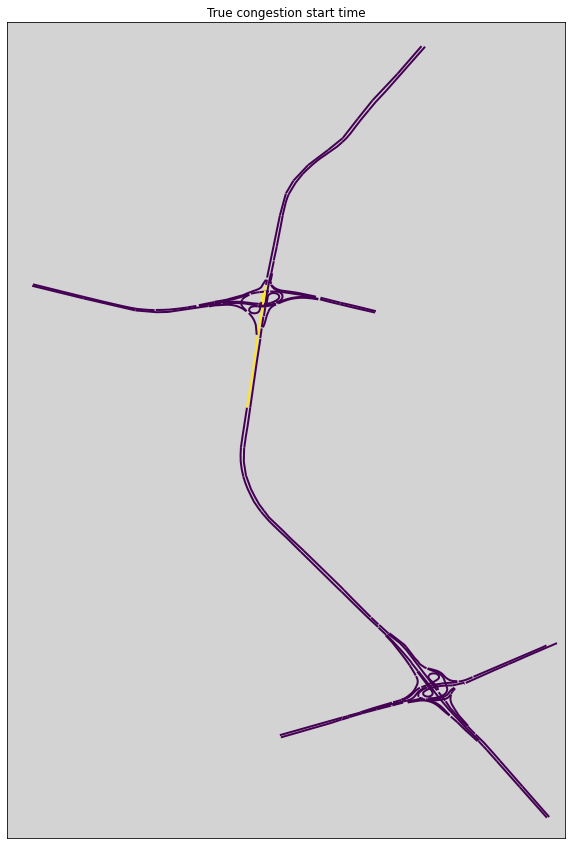

In [24]:
widths = {}
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
area = {'xmin':500, 'xmax':4500,'ymin':750, 'ymax':9500}

selected_edges = torch.zeros(147)
selected_edges[test_edge_idxs] = 1

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, figsize=(10,15))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=selected_edges, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        area=area,
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax.set_title('True congestion start time')
ax.set_facecolor('lightgray')
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

In [23]:
input_full = torch.Tensor(np.load(f'{folder_path}/input_data.npy'))
input_obs_full = input_full[...,:-2]
input_time_full = input_full[...,-2:]
target_full = torch.Tensor(np.load(f'{folder_path}/target_data.npy'))
incident_info_full = torch.Tensor(np.load(f'{folder_path}/incident_info.npy'))
network_info_full = torch.Tensor(np.load(f'{folder_path}/network_info.npy'))

In [33]:
target_full[...,0].sum(1) > 5

tensor([False,  True, False,  ..., False,  True, False])

In [26]:
spatial_test_mask = sum(incident_info_full[...,0] == edge_idx for edge_idx in test_edge_idxs).bool()

In [27]:
ie_sorted_sims_arr = []
num_sims_arr = []
mean_impact_arr = []
std_impact_arr = []
for i in range(147):
    ie_edge_mask = incident_info_full[...,0] == i
    ie_sorted_sims_arr.append(target_full[ie_edge_mask])
    
    ie_sims = ie_sorted_sims_arr[i]
    num_sims = ie_sims.shape[0]
    num_sims_arr.append(num_sims)

    mean_impact_arr.append(ie_sims[...,0].sum(1).mean())
    std_impact_arr.append(ie_sims[...,0].sum(1).std())
    # print(f'Number of sims w. IE idx {i}: {num_sims} mean impact: {mean_impact}')
    
    

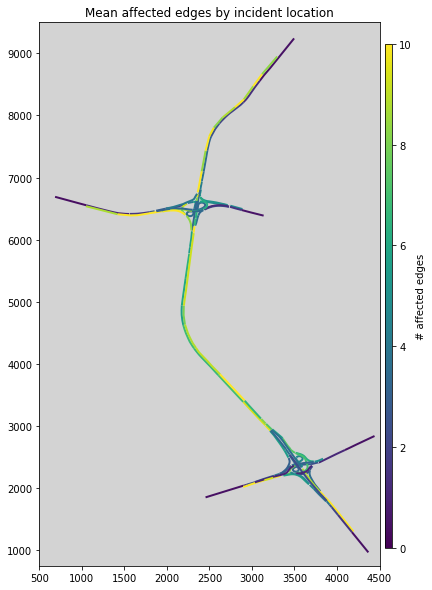

In [28]:
norm = mcolors.Normalize(vmin=0, vmax=10)
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, figsize=(7,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=mean_impact_arr, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        area=area,
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax.set_title('Mean affected edges by incident location')
ax.set_facecolor('lightgray')

plt.subplots_adjust(wspace=0.01, hspace=0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('# affected edges')

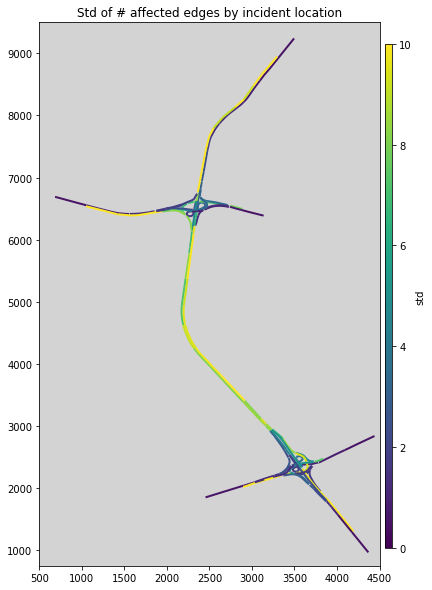

In [29]:
norm = mcolors.Normalize(vmin=0, vmax=10)
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, figsize=(7,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=std_impact_arr, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        area=area,
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax.set_title('Std of # affected edges by incident location')
ax.set_facecolor('lightgray')

plt.subplots_adjust(wspace=0.01, hspace=0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('std')

In [15]:
ie_blocked_lanes = 6

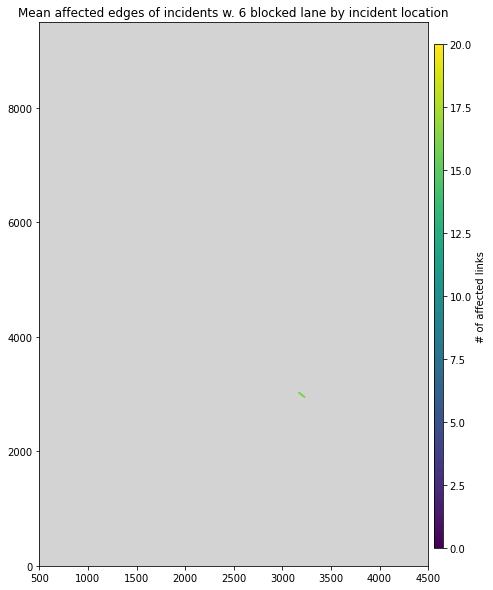

In [23]:

num_lanes_mask = incident_info_full[...,1] == ie_blocked_lanes
ie_sorted_sims_arr = []
num_sims_arr = []
mean_impact_arr = []
std_impact_arr = []
for i in range(147):
    ie_edge_mask = incident_info_full[...,0] == i

    ie_lane_mask = ie_edge_mask * num_lanes_mask
    
    ie_sorted_sims_arr.append(target_full[ie_lane_mask])
    
    ie_sims = ie_sorted_sims_arr[i]
    num_sims = ie_sims.shape[0]
    num_sims_arr.append(num_sims)

    mean_impact_arr.append(ie_sims[...,0].sum(1).mean())
    std_impact_arr.append(ie_sims[...,0].sum(1).std())
    # print(f'Number of sims w. IE idx {i}: {num_sims} mean impact: {mean_impact}')

norm = mcolors.Normalize(vmin=0, vmax=20)
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, figsize=(8,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=mean_impact_arr, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        area=area,
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax.set_title(f'Mean affected edges of incidents w. {ie_blocked_lanes} blocked lane by incident location')
ax.set_facecolor('lightgray')

plt.subplots_adjust(wspace=0.01, hspace=0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('# of affected links')

In [17]:
num_lanes_mask = incident_info_full[...,1] == 4
ie_edge_mask = incident_info_full[...,0] == 93
full_mask = num_lanes_mask * ie_edge_mask

In [18]:
sim_tests = target_full[full_mask][...,0]

In [19]:
sim_times = input_full[full_mask][:,0,0,0,-2:]

In [21]:
sim_tests[0]

tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

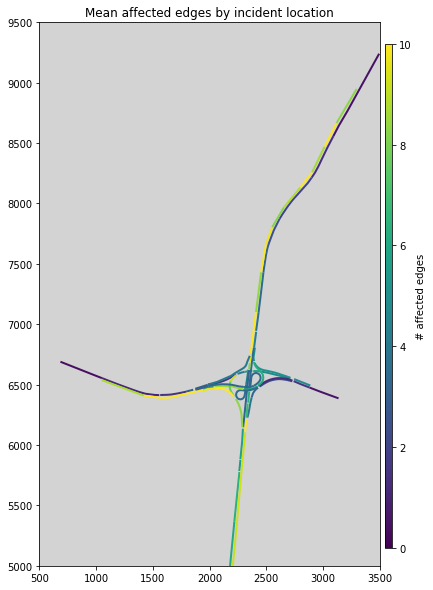

In [33]:
area = {'xmin':500, 'xmax':3500,'ymin':5000, 'ymax':9500}

norm = mcolors.Normalize(vmin=0, vmax=10)
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, figsize=(7,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=mean_impact_arr, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        area=area,
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax.set_title('Mean affected edges by incident location')
ax.set_facecolor('lightgray')

plt.subplots_adjust(wspace=0.01, hspace=0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('# affected edges')

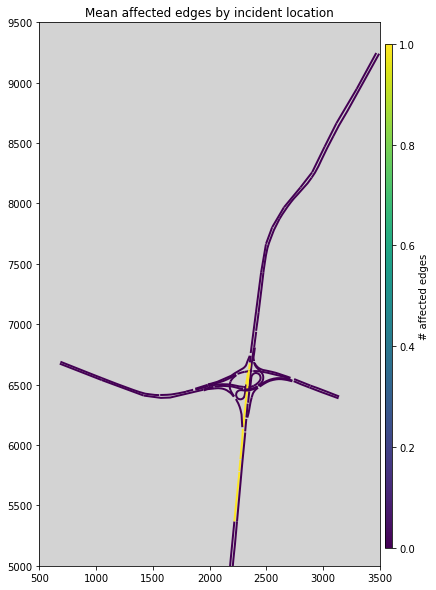

In [34]:
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, figsize=(7,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=selected_edges, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        area=area,
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax.set_title('Mean affected edges by incident location')
ax.set_facecolor('lightgray')

plt.subplots_adjust(wspace=0.01, hspace=0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('# affected edges')

In [44]:
test_edges = ['4414080#0.187', 
                '4414080#0.756', 
                '4414080#0', 
                '332655581', 
                '360361373-AddedOffRampEdge', 
                '360361373.2643',
                '71324924',
                '146909950#1',
                '146909950#0',
                '48516115',
                '48516117.389',
                '48516117',
                '4414080#0.756.47',
                '4414080#1-AddedOnRampEdge',
                '4414080#1-AddedOnRampEdge.343',
                '4414080#1-AddedOnRampEdge.675',
                
                
]

selected_edges = torch.zeros(147)
edge_to_ind = {v:k for k, v in ind_to_edge.items()}
test_edge_idxs = torch.tensor([int(edge_to_ind[edge]) for edge in test_edges])
selected_edges[test_edge_idxs] = 1

In [47]:
test_edge_idxs

tensor([ 80,  81,  79,  53,  59,  64, 128,  15,  14, 100, 102, 101,  82,  83,
         84,  85])

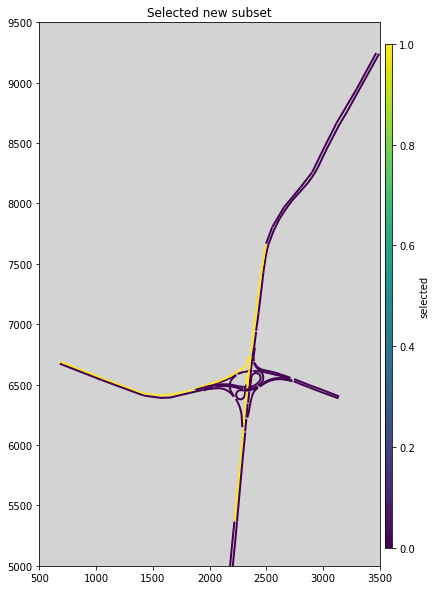

In [48]:

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, figsize=(7,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=selected_edges, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        area=area,
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax.set_title('Selected new subset')
ax.set_facecolor('lightgray')

plt.subplots_adjust(wspace=0.01, hspace=0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('selected')

lanes_blockes 1 mean affected edges 2.2941176891326904
lanes_blockes 2 mean affected edges 3.090909004211426
lanes_blockes 3 mean affected edges 4.538461685180664
lanes_blockes 4 mean affected edges 5.9285712242126465
lanes_blockes 5 mean affected edges 5.800000190734863


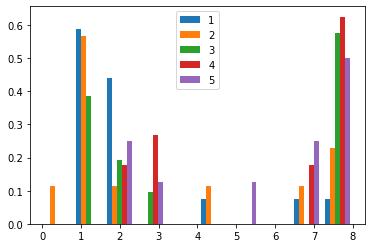

In [53]:
ie_edge_mask = incident_info_full[...,0] == 1
num_blockd_lanes = incident_info_full[ie_edge_mask][...,1]
max_lanes = num_blockd_lanes.max()

affected_by_lane = []
for i in range(1, int(max_lanes)+1):
    num_lanes_mask = num_blockd_lanes == i 
    ie_targets = target_full[ie_edge_mask]
    ie_num_lanes_target = ie_targets[num_lanes_mask][...,0].sum(1)
    affected_by_lane.append(ie_num_lanes_target)
    print(f'lanes_blockes {i} mean affected edges {ie_num_lanes_target.mean()}')
plt.hist(affected_by_lane, density=True, label=range(1, int(max_lanes)+1))
plt.legend()